In [28]:
#Imports

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import tqdm
from sklearn.metrics import f1_score

class ModelLSTM(nn.Module):
	def __init__(self, input_types, relation_types, model_dim, dropout = 0.0):
		super().__init__()

		self.word_types = input_types
		self.relation_types = relation_types
		self.dropout = dropout
		self.model_dim = model_dim

		self.emb = nn.Embedding(input_types, self.model_dim)
		self.lstm = nn.LSTM(self.model_dim, self.model_dim//2, batch_first=True, bidirectional=True, num_layers=2)
		self.relation_layer1 = nn.Linear(self.model_dim , self.model_dim)
		self.relation_layer2 = nn.Linear(self.model_dim , self.model_dim)
		self.drop = nn.Dropout(self.dropout)
		self.projection = nn.Linear(self.model_dim , self.model_dim)
		self.decoder = nn.Linear(self.model_dim , self.relation_types)
		self.layer_norm = nn.LayerNorm(self.model_dim)

		self.init_params()

	def init_params(self):
		nn.init.xavier_normal_(self.relation_layer1.weight.data)
		nn.init.xavier_normal_(self.relation_layer2.weight.data)
		nn.init.xavier_normal_(self.projection.weight.data)
		nn.init.xavier_normal_(self.decoder.weight.data)

		nn.init.constant_(self.relation_layer1.bias.data , 0)
		nn.init.constant_(self.relation_layer2.bias.data , 0)
		nn.init.constant_(self.projection.bias.data , 0)
		nn.init.constant_(self.decoder.bias.data , 0)

	#def forward(self, batch):
	def forward(self, sents, ent_inds, max_ents):
		#sents = batch['text']
		sents, (c_0, h_0) = self.lstm(self.emb(sents))

		bs, _, hidden_dim = sents.shape
		
		#max_ents = max([max([ent_ind[0] for ent_ind in batch_ent_inds]) for batch_ent_inds in ent_inds]).item() + 1
		max_ents = max_ents.item()

		cont_word_mask = sents.new_zeros(bs, max_ents)
		cont_word_embs = sents.new_zeros(bs, max_ents, hidden_dim)

		#for b, (sent,entind) in enumerate(zip(sents,batch['entity_inds'])):
		for b, (sent,entind) in enumerate(zip(sents, ent_inds)):
			for z in entind:
				if z[0] == -1:
					break
				else:
					wordemb = sent[z[1]:z[2]]
					#cont_word_embs[b, z[0]] = (cont_word_mask[b, z[0]]*cont_word_embs[b, z[0]] + torch.mean(wordemb, dim = 0))/(cont_word_mask[b, z[0]] + 1)
					#FUCK, try ignoring repeats for now :(
					cont_word_embs[b, z[0]] = torch.mean(wordemb, dim =0)
					cont_word_mask[b, z[0]] = 1

		# bs x max_ents x model_dim
		cont_word_embs = self.layer_norm(cont_word_embs)
		cont_word_mask = torch.clamp(cont_word_mask, 0, 1)

		rel1 = self.relation_layer1(cont_word_embs)
		rel2 = self.relation_layer2(cont_word_embs)

		#bs x max_ents x max_ents x model_dim
		out = rel1.unsqueeze(1) + rel2.unsqueeze(2)

		out = F.relu(self.drop(out))
		out = F.relu(self.projection(out))
		out = self.decoder(out)

		out = out * cont_word_mask.view(bs,max_ents,1,1) * cont_word_mask.view(bs,1,max_ents,1)

		return torch.log_softmax(out, -1) # bs x max ents x max_ents x num_relations

class T2GModel():
	def __init__(self, vocab, device, model_dim):
		self.inp_types = len(vocab.entities.wordlist) + len(vocab.text.wordlist)
		self.rel_types = len(vocab.relations.wordlist)

		self.model = ModelLSTM(self.inp_types, self.rel_types, model_dim = model_dim).to(device)
		self.vocab = vocab
		self.device = device

	def eval(self):
		self.model.eval()
    
	def train(self):
		self.model.train()
	def t2g_preprocess(self, batch):
			""" 
				input: list of dictionaries in raw_json_format
				output: prepreprocessed dictionaries containing text, entity inds
			"""

			def entity2Indices(entity, mode = "T2G"):
				temp = torch.zeros(len(entity), dtype = torch.long)
				for ind, word in enumerate(entity):
					if word not in self.vocab.entities.word2idx:
						temp[ind] = self.vocab.entities.word2idx["<UNK>"]
					else:
						temp[ind] = self.vocab.entities.word2idx[word]
				return temp
					
			def text2Indices(text):
				temp = torch.zeros(len(text.split()) + 2, dtype=torch.long)
				temp[0] = self.vocab.text.word2idx["<SOS>"]
				for ind, word in enumerate(text.split()):
					if word not in self.vocab.text.word2idx:
						temp[ind + 1] = self.vocab.text.word2idx["<UNK>"]
					else:
						temp[ind + 1] = self.vocab.text.word2idx[word]
				temp[-1] = self.vocab.text.word2idx["<EOS>"]
				return temp

			def concatTextEntities(raw_json_sentence):
				sent = text2Indices(raw_json_sentence['text'])
				modified_input = torch.LongTensor([0])
				lbound = 0
				entity_locations = []
				additional_words = 0
				for index, value in enumerate(sent):
					if value.item() in self.vocab.entityindices:
						temp = entity2Indices(raw_json_sentence['entities'][self.vocab.entityindices[value.item()]])
						temp += len(self.vocab.text.wordlist)
						modified_input = torch.cat((modified_input, sent[lbound:index], temp), dim = 0)
						entity_locations.append([self.vocab.entityindices[value.item()], index + additional_words, index + additional_words + len(temp)])
						additional_words += len(temp) - 1
						lbound = index + 1
				modified_input = torch.cat((modified_input, sent[lbound:]), dim = 0)[1:]
				return modified_input, torch.LongTensor(entity_locations)

			maxlentext = 0
			maxents = 0
			temp_text = []
			temp_inds = []
			skipped = 0
			for k, raw_json_sentence in enumerate(batch):
				
				(text, entity_inds) = concatTextEntities(raw_json_sentence)
				if len(entity_inds) == 0:
					skipped += 1
					continue
				temp_inds.append(entity_inds)
				if len(entity_inds) > maxents:
					maxents = len(entity_inds)
				temp_text.append(text)
				if text.shape[0] > maxlentext:
					maxlentext = text.shape[0]
				
			final_text = torch.ones((len(batch)-skipped, maxlentext), dtype = torch.long)*self.vocab.text.word2idx["<EMPTY>"]
			final_ents = torch.ones((len(batch)-skipped, maxents, 3), dtype = torch.long)*-1

			for k in range(len(batch)-skipped):
				# print(temp_text[k], temp_inds[k])
				# print(len(temp_text[k]), len(temp_inds[k]), k)
				final_text[k][:len(temp_text[k])] = temp_text[k]
				final_ents[k][:len(temp_inds[k])] = temp_inds[k]
			
			return final_text, final_ents

	# input - texts with original entities taken out (list of dicts with text and entities)
	# output - batch of graphs (list of dicts with relations and entities)
	def predict(self, batch):
		preprocessed_text, preprocessed_inds = self.t2g_preprocess(batch)
		max_ents = max([len(graph["entities"]) for graph in batch])

		#preds = self.model(preprocessed_text.to(self.device), preprocessed_inds.to(self.device))
		preds = self.model(preprocessed_text.to(self.device), preprocessed_inds.to(self.device), torch.tensor(max_ents).to(self.device))
		preds = torch.argmax(preds, -1)

		bs, ne, _ = preds.shape

		output = [] #list of dictionaries

		#print(ne, max([len(batch[b]['entities'])] for b in range(bs)))
		assert ne == max([len(batch[b]['entities'])] for b in range(bs))[0]

		for b in range(bs):
			temp = {
				"relations": [],
				"entities": batch[b]['entities']
			}
			for i in range(0, ne):
				for j in range(i+1, ne):
					temp['relations'].append([temp['entities'][i], self.vocab.relations.wordlist[preds[b, i, j]], temp['entities'][j]])
			output.append(temp)
		return output

	def eval_t2g(self, eval_dataset):
		def relation2Indices(raw_json_sentence, max_ents):
			'''
				Parameters:
					vocab - Vocabulary object that contains the vocab from a parsed json file
					raw_json_sentence - one element of array (i.e. one dict) contained in raw json file
					max_ents - gives size of return array

				Return:
					labels - Symmetrical [max_entities x max_entities)] Longtensor where 
									labels[i][j] denotes the relation between entities i and j.
							Anything where i >= l or j >= l is <EMPTY> 
			'''
			l = len(raw_json_sentence['entities'])
			ret = torch.ones((max_ents,max_ents), dtype = torch.long)*self.vocab.relations.word2idx["<NO_RELATION>"]
			for i in range(l, max_ents):
				for j in range(0, max_ents):
					ret[i][j] = ret[j][i] = self.vocab.relations.word2idx["<EMPTY>"]
			
			for i in range(0, l):
				for j in range(0, i+1):
					ret[i][j] = self.vocab.relations.word2idx["<EMPTY>"]
					
			# for i in range(l, max_ents):
			# 	for j in range(0, max_ents): # could do (0, l) for efficiency
			# 		ret[j][i] = vocab.relations.word2idx["<EMPTY>"]
			entitydict = {}
			for i, entity in enumerate(raw_json_sentence['entities']):
				entitydict["".join(entity)] = i
			for relation in raw_json_sentence['relations']:
				ind1 = entitydict["".join(relation[0])]
				ind2 = entitydict["".join(relation[2])]
				if relation[1] not in self.vocab.relations.word2idx:
					rep = self.vocab.relations.word2idx['<UNK>']
				else:
					rep = self.vocab.relations.word2idx[relation[1]]
				#ret[ind1][ind2] = ret[ind2][ind1] = vocab.relations.word2idx[relation[1]]
				if ind1 < ind2:
					ret[ind1][ind2] = rep
					#self.vocab.relations.word2idx[relation[1]]
					#ret[ind2][ind1] = self.vocab.relations.word2idx["<EMPTY>"]
				else:
					ret[ind2][ind1] = rep
					#self.vocab.relations.word2idx[relation[1]]
					#ret[ind1][ind2] = self.vocab.relations.word2idx["<EMPTY>"]
			return ret

		self.model.eval()
		preprocessed_text, preprocessed_inds = self.t2g_preprocess(eval_dataset)
		max_ents = max([len(graph["entities"]) for graph in eval_dataset])

		preprocessed_labels = [relation2Indices(json_sent, max_ents) for json_sent in eval_dataset]

		
		preds = self.model(preprocessed_text.to(self.device), preprocessed_inds.to(self.device), torch.tensor(max_ents))
		preds = torch.argmax(preds, -1)

		bs, ne, _ = preds.shape

		true_labels = []
		pred_labels = []

		for b in range(bs):
			temp_true = []
			temp_pred = []
			for i in range(0, len(eval_dataset[b]['entities'])):
				for j in range(i+1, len(eval_dataset[b]['entities'])):
					temp_true.append(preprocessed_labels[b][i][j].item())
					temp_pred.append(preds[b][i][j].item())
			true_labels.extend(temp_true)
			pred_labels.extend(temp_pred)

		# print("Micro F1: ", f1_score(true_labels, pred_labels, average = 'micro'))
		# print("Macro F1: ", f1_score(true_labels, pred_labels, average = 'macro'))
		#print("true", true_labels)
		#print("pred", pred_labels)
		return f1_score(true_labels, pred_labels, average = 'micro'), f1_score(true_labels, pred_labels, average = 'macro'), true_labels, pred_labels

In [29]:
# importing the module
import json

import data_processing as dp
  
# Opening JSON file
f = open('json_datasets/train.json', 'r')

raw_train = json.load(f)

vocab = dp.Vocabulary()
vocab.parseText(raw_train)

inp_types = len(vocab.entities.wordlist) + len(vocab.text.wordlist)
rel_types = len(vocab.relations.wordlist)

t2g_model = T2GModel(vocab, torch.device('cpu'), 512)

Creating empty vocabulary object
Finished Parsing Text


In [59]:
f = open('json_datasets/dev.json', 'r')

raw_dev = json.load(f)

In [31]:
import tqdm
def train_model_supervised(model, num_relations, warmup_epochs = 3, learning_rate = 5.0e-5, epochs = 20):
	"""
	"""

	# Create model
	optimzer = torch.optim.Adam(model.model.parameters(), lr = learning_rate)
	best_acc = 0
	state_dict_clone = {k: v.clone() for k, v in model.model.state_dict().items()}
	for p in range(epochs):
		model.model.train()
		if p < warmup_epochs:
			t, g = dp.create_cycle_dataloader(model.vocab.raw_data[:3550], 32, True)
			dataloader = t+g

		else:
			t, g = dp.create_cycle_dataloader(model.vocab.raw_data, 32, True)
			dataloader = t+g
		
		loss_this_epoch = 0.0
		for index, batch in tqdm.tqdm(enumerate(dataloader)):
			pre_text, pre_ents = model.t2g_preprocess(batch)

			bs, _ = pre_text.shape

			max_ents = max([len(ex['entities']) for ex in batch])

			labels = torch.zeros((bs, max_ents, max_ents), dtype = torch.long)
			for k, raw_json in enumerate(batch):
				labels[k] = dp.relation2Indices(vocab, raw_json, max_ents)
    
			log_probs = model.model(pre_text, pre_ents, torch.tensor(max_ents))

			loss = F.nll_loss(log_probs.view(-1, num_relations), labels.view(-1), ignore_index = 0)
			loss_this_epoch += loss.item()
			optimzer.zero_grad()
			loss.backward()
			# torch.nn.utils.clip_grad_norm_(
			#     [p for group in optimzer.param_groups for p in group['params']], CLIP)
			optimzer.step()

		print("Evaluating: ")
		micro, macro = model.eval_t2g(raw_dev)
		if (micro + macro)/2 > best_acc:
			best_acc = (micro+macro)/2
			curr_state_dict = model.model.state_dict()
			for key in state_dict_clone.keys():
				state_dict_clone[key].copy_(curr_state_dict[key])
		

		print("Loss this epoch: ", loss_this_epoch/len(dataloader)*32)

	curr_state_dict = model.model.state_dict()
	for key in state_dict_clone.keys():
		curr_state_dict[key].copy_(state_dict_clone[key])

	print("saving model")
	torch.save(curr_state_dict, "sup_t2g_dict")
	return curr_state_dict

In [63]:

f = open('json_datasets/test.json', 'r')

raw_test = json.load(f)

state_dict = train_model_supervised(t2g_model, rel_types)

newt2g = T2GModel(vocab, torch.device('cpu'), 512)
newt2g.model.load_state_dict(torch.load(state_dict))

newt2g.model.eval_t2g(raw_test)

112it [00:38,  2.87it/s]


Evaluating: 
Micro F1:  0.3147794860285041
Macro F1:  0.2877418594686414
Loss this epoch:  19.134619644709996


112it [00:39,  2.84it/s]


Evaluating: 
Micro F1:  0.3136572775221636
Macro F1:  0.313536738101139
Loss this epoch:  7.801497391292027


112it [00:39,  2.82it/s]


Evaluating: 
Micro F1:  0.30366962181573337
Macro F1:  0.3286502406675935
Loss this epoch:  4.108408265880176


408it [05:23,  1.26it/s]


Evaluating: 
Micro F1:  0.889574682976097
Macro F1:  0.6632417750633345
Loss this epoch:  20.380990314717387


408it [05:25,  1.25it/s]


Evaluating: 
Micro F1:  0.9426551453260016
Macro F1:  0.787299715101523
Loss this epoch:  6.944567600886027


408it [05:20,  1.27it/s]


Evaluating: 
Micro F1:  0.9535405678375042
Macro F1:  0.8225576085950439
Loss this epoch:  3.652829088416754


408it [05:24,  1.26it/s]


Evaluating: 
Micro F1:  0.9587027269666704
Macro F1:  0.8488844686926321
Loss this epoch:  2.2575922634671715


408it [05:24,  1.26it/s]


Evaluating: 
Micro F1:  0.9640893277971047
Macro F1:  0.8918813639272277
Loss this epoch:  1.5432427749037743


408it [05:23,  1.26it/s]


Evaluating: 
Micro F1:  0.9691392660756368
Macro F1:  0.8938737769987949
Loss this epoch:  1.1086908093124044


408it [05:21,  1.27it/s]


Evaluating: 
Micro F1:  0.9675681741667602
Macro F1:  0.8931232491485994
Loss this epoch:  0.877898744837034


408it [05:22,  1.26it/s]


Evaluating: 
Micro F1:  0.9688026035237347
Macro F1:  0.8981616302385443
Loss this epoch:  0.735623373777843


408it [05:21,  1.27it/s]


Evaluating: 
Micro F1:  0.9700370328807092
Macro F1:  0.9017985048863196
Loss this epoch:  0.6134685056612772


408it [05:21,  1.27it/s]


Evaluating: 
Micro F1:  0.9699248120300752
Macro F1:  0.9171596885920368
Loss this epoch:  0.5616663481090584


408it [05:21,  1.27it/s]


Evaluating: 
Micro F1:  0.9711592413870497
Macro F1:  0.9135588628918783
Loss this epoch:  0.5221144515728834


408it [05:33,  1.22it/s]


Evaluating: 
Micro F1:  0.9707103579845135
Macro F1:  0.9095904290503466
Loss this epoch:  0.47885655672015515


408it [05:51,  1.16it/s]


Evaluating: 
Micro F1:  0.9717203456402199
Macro F1:  0.9067088408348797
Loss this epoch:  0.41459838233376833


408it [05:21,  1.27it/s]


Evaluating: 
Micro F1:  0.9692514869262709
Macro F1:  0.9051281406476812
Loss this epoch:  0.38651329441470844


408it [05:28,  1.24it/s]


Evaluating: 
Micro F1:  0.9710470205364157
Macro F1:  0.9118795646956618
Loss this epoch:  0.34094837370931225


408it [05:22,  1.26it/s]


Evaluating: 
Micro F1:  0.9709347996857817
Macro F1:  0.9061206919229854
Loss this epoch:  0.3152650249939339


408it [05:18,  1.28it/s]


Evaluating: 
Micro F1:  0.9704859162832454
Macro F1:  0.9088879613338899
Loss this epoch:  0.33369245508904843
saving model


AttributeError: 'collections.OrderedDict' object has no attribute 'seek'. You can only torch.load from a file that is seekable. Please pre-load the data into a buffer like io.BytesIO and try to load from it instead.

In [40]:

f = open('json_datasets/test.json', 'r')

raw_test = json.load(f)

import random
indices = np.arange(0, len(raw_test))
random.shuffle(indices)


index = 0
tr = pre = []

newt2g = T2GModel(vocab, torch.device('cpu'), 512)
newt2g.model.load_state_dict(torch.load('sup_t2g_dict'))
while index + 100 < len(raw_test):
	_,_, t, p = newt2g.eval_t2g(raw_test[index: index+100])
	tr.extend(t)
	pre.extend(p)
	index += 100

print(f1_score(tr, pre, average = "micro"))
print(f1_score(tr, pre, average = "macro"))

# newt2g = T2GModel(vocab, torch.device('cpu'), 512)
# newt2g.model.load_state_dict(torch.load('sup_t2g_dict_jeff'))
# newt2g.eval_t2g(np.array(raw_test)[indices])

1.0
1.0


In [52]:
micro, macro, t, p = newt2g.eval_t2g(np.array(raw_test)[::-1])

In [53]:
print(micro, macro)

0.43144282173043036 0.008136938874955328


In [18]:
raw_test[2000]

{'relations': [[['Bionico'], 'country', ['Mexico']],
  [['Bionico'], 'course', ['Dessert']],
  [['Bionico'], 'region', ['Jalisco']],
  [['Bionico'], 'ingredient', ['Granola']]],
 'text': 'the <ENT_2> -based <ENT_3> <ENT_0> is a food found in <ENT_1> , <ENT_4> .',
 'entities': [['Bionico'], ['Jalisco'], ['Granola'], ['Dessert'], ['Mexico']]}

In [86]:
newt2g.t2g_preprocess(raw_test[940:941])

tensor([   2,  551,    1,  884,   55, 3037,    1,  520,  568,  522,    1,    1,
           1,    3]) tensor([], dtype=torch.int64)
14 0 0


RuntimeError: The expanded size of the tensor (3) must match the existing size (0) at non-singleton dimension 1.  Target sizes: [0, 3].  Tensor sizes: [0]

In [34]:
y_true = [torch.tensor(1),torch.tensor(0),torch.tensor(1),torch.tensor(0)]
y_pred = [torch.tensor(2),torch.tensor(0),torch.tensor(1),torch.tensor(0)]

f1_score(y_true=y_true, y_pred=y_pred, average = "macro")

0.5555555555555555

C:\Users\Jeffrey\AppData\Local\Temp/ipykernel_29408/3060068809.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


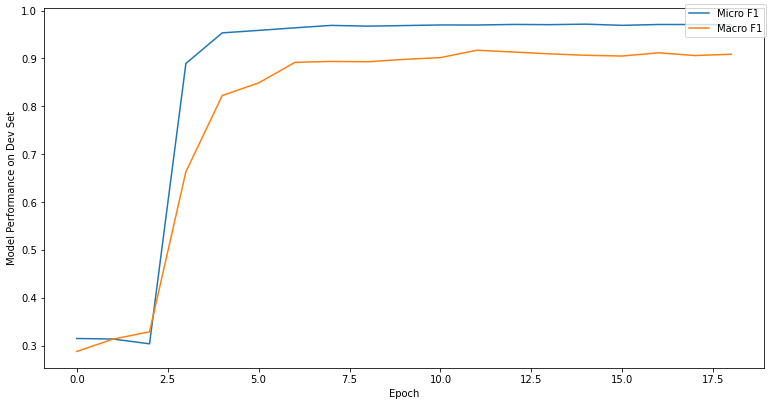

In [4]:
micro_array = [0.3147794860285041, 0.3136572775221636, 0.30366962181573337, 0.889574682976097, 0.9535405678375042, 0.9587027269666704, 0.9640893277971047, 0.9691392660756368, 0.9675681741667602, 0.9688026035237347, 0.9700370328807092, 0.9699248120300752, 0.9711592413870497, 0.9707103579845135, 0.9717203456402199, 0.9692514869262709, 0.9710470205364157, 0.9709347996857817, 0.9704859162832454]
macro_array = [0.2877418594686414, 0.313536738101139, 0.3286502406675935, 0.6632417750633345, 0.8225576085950439, 0.8488844686926321, 0.8918813639272277, 0.8938737769987949, 0.8931232491485994, 0.8981616302385443, 0.9017985048863196, 0.9171596885920368, 0.9135588628918783, 0.9095904290503466, 0.9067088408348797, 0.9051281406476812, 0.9118795646956618, 0.9061206919229854, 0.9088879613338899]


import matplotlib.pyplot as plt
fig = plt.figure(figsize = (10,5))
ax = fig.add_axes([0,0,1,1])
ax.plot([tuple([type[i-1] for type in [micro_array, macro_array]]) for i in range(1, 20)])
plt.xlabel("Epoch")
plt.ylabel("Model Performance on Dev Set")
fig.legend(["Micro F1", "Macro F1"])
fig.show()